# <center>Generative Implied Volatility Modelling with Diffusion Models</center>
##  <center>*Volatility dynamics in the 0DTE regime (2022-now)*</center>

<style>
  h1 {
    font-size: 25px;
  }
  h2 {
    font-size: 20px;
  }
  p {
    font-size: 14px;
  }
</style>

This notebook is a walkthrough for the code from my Master thesis *"[Generative Implied Volatility Modelling in the Era of 0DTE Options](https://www.example.com)"*. The goal is to train an unconditional diffusion model on volatility shocks of SPX option surfaces sampled once per day near market close since the introduction of daily options in 2022. The mathematical description of these volatility shocks requires quite some technicalities so we refer the reader to the paper for details. Once trained, the diffusion model can sample new volatility shocks - like all ML models, it yields an interpolation (and hopefully a reasonable generalisation) of the training set. Arbitrage-free surfaces are guaranteed by projecting with [ArbitrageRepair](https://github.com/vicaws/arbitragerepair) if needed, although clean data and correct training should be enough to avoid it. By subsampling the data set with a kNN algorithm, we can perform conditional sampling on *arbitrary* alpha signals, facilitating scenario forecasting and pure alpha generation. Use cases include SPX/NDX/RUT option market makers assessing their greek exposure across the entire volatility surface, and volatility hedge funds seeking sophisticated multi-leg multi-expiry strategies.

<span style="color:blue">**Step 1:** </span> Let's start by visualising the first 8 volatility shocks in the dataset. This is proprietary, so you will need to acquire your own and load it as a .pt file. Note that moneyness and time to maturity can be chosen arbitrarily; I am using the first 16 expiries on the SPX, and a moneyness range of 95% to 105% since we are dealing with extremely short-maturity options.
<style>
  h1 {
    font-size: 25px;
  }
  h2 {
    font-size: 20px;
  }
  p {
    font-size: 14px;
  }
</style>

Shape: torch.Size([246, 1, 16, 32])


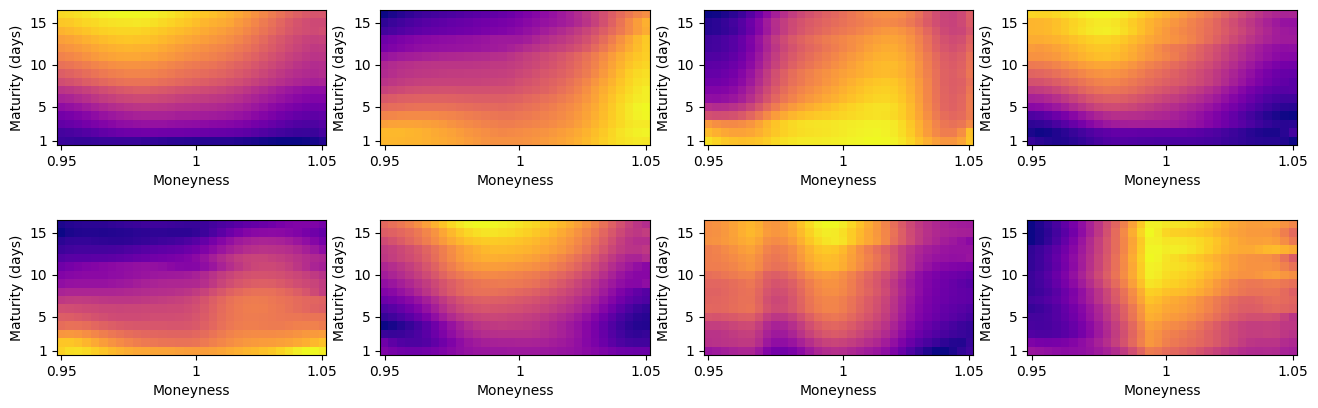

In [1]:
from diffusion import *

file="vol_data.pt" #proprietary dataset, use your own file here ;)

data = torch.load(file, weights_only=True)
print(f"Shape: {data.shape}")
images = data[:8]

fig, axes = plt.subplots(2, 4, figsize=(16, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='plasma')
    ax.set_xlabel('Moneyness')
    ax.set_ylabel('Maturity (days)')
    ax.set_xticks([0, images[i].shape[2] // 2, images[i].shape[2] - 1])
    ax.set_xticklabels([0.95,1,1.05])
    ax.set_yticks([0, 4, 9,14])
    ax.set_yticklabels([1,5,10,15])
    ax.invert_yaxis()

plt.show()

Evidently, these volatility shocks are quite rich. A flat volatility shock (constant colour) would correspond to a global, uniform increase in all volatilities, so what we are observing is relative changes in volatilities across the entire option surface, *discounted* by the maturation of the surface (more details in the paper!).

<span style="color:blue">**Step 2:** </span> Let's train *VolaDiff* for a few epochs to get a feel for the training.
<style>
  h1 {
    font-size: 25px;
  }
  h2 {
    font-size: 20px;
  }
  p {
    font-size: 14px;
  }
</style>

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 0, NMSE: 0.5918, best NMSE: 0.5918


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 1, NMSE: 0.3681, best NMSE: 0.3681


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 2, NMSE: 0.2156, best NMSE: 0.2156


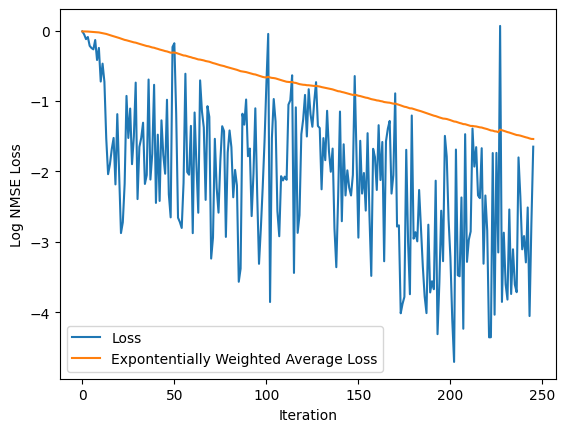

Training complete. Best NMSE: 0.21555245168259418


In [2]:
model=VolaDiff()
vol_data=VolDataset(file)
params={'batch_size':3,'shuffle':True,'drop_last':True}
VolDataLoader=DataLoader(vol_data,**params)
model.train(VolDataLoader,params,n_epochs=3,save_model=True,plotting=True,printing=True) #set printing to True to gauge training speed

<span style="color:blue">**Step 3:** </span> Once training finishes, the model is saved automatically to "best_model_checkpoint.pt" which we can load and sample from.
<style>
  h1 {
    font-size: 25px;
  }
  h2 {
    font-size: 20px;
  }
  p {
    font-size: 14px;
  }
</style>

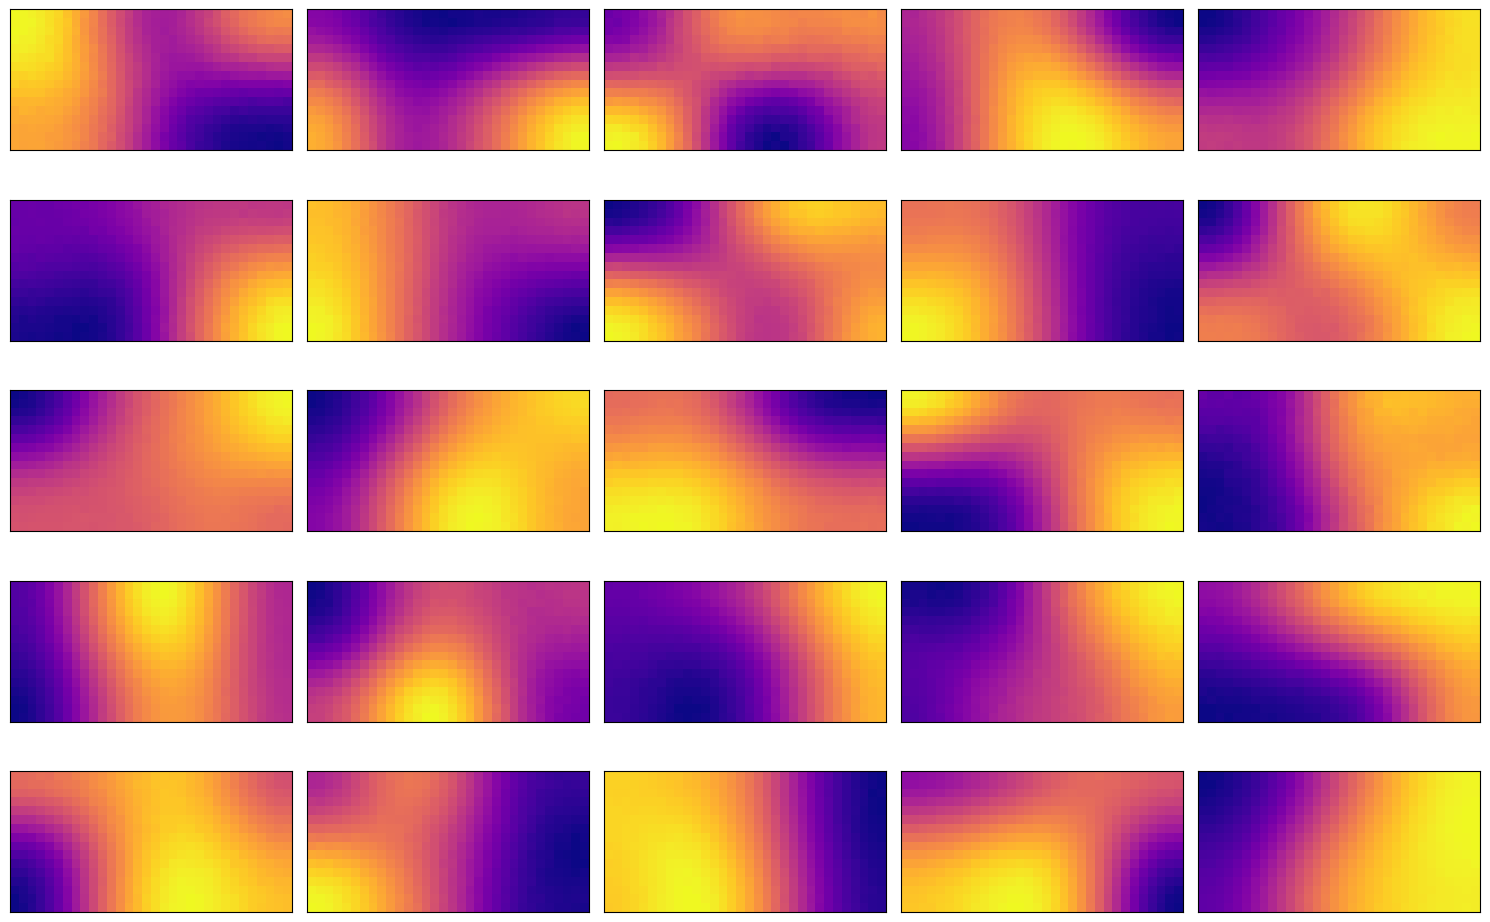

In [15]:
model.load("best_model_checkpoint.pt")

n_samples=25
sample_unconditional=model.sample_uncond(n_samples).detach().cpu().numpy()

fig, axes = plt.subplots(5, 5, figsize=(15, 10))

for sample_idx in range(n_samples):
    ax = axes[sample_idx // 5, sample_idx % 5]
    ax.imshow(sample_unconditional[sample_idx, 0, :, :], cmap='plasma')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

Notice how smooth the surfaces are! This is partly due to the spectral bias of neural networks, and partly due to the diffusion model architecture. Using large 5x5 kernels, a low parameter count, and SiLU (not ReLU!) activations promotes smooth surfaces - a critical feature for realistic volatility shocks since they are smooth by construction (for index options at least).

<span style="color:blue">**Step 4:** </span> Let us now fit the model fully. Note that diffusion models generally exhibit surprising training dynamics; their loss function will seem to plateau, but the test performance and realism of generated images continues to improve. This is because the network is learning to denoise at wildly different signal-to-noise ratios, and learning all scales can take a while. In this case, 1000 epochs tend to work well.
<style>
  h1 {
    font-size: 25px;
  }
  h2 {
    font-size: 20px;
  }
  p {
    font-size: 14px;
  }
</style>

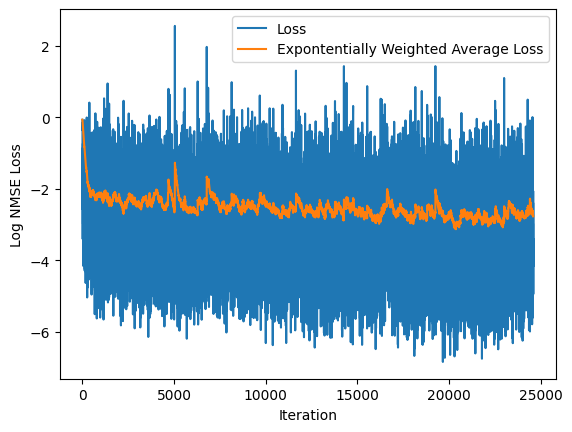

Training complete. Best NMSE: 0.04364009828223788


In [2]:
model=VolaDiff()
vol_data=VolDataset(file)
params={'batch_size':3,'shuffle':True,'drop_last':True}
VolDataLoader=DataLoader(vol_data,**params)
model.train(VolDataLoader,params,n_epochs=300,save_model=True,plotting=True,printing=False)

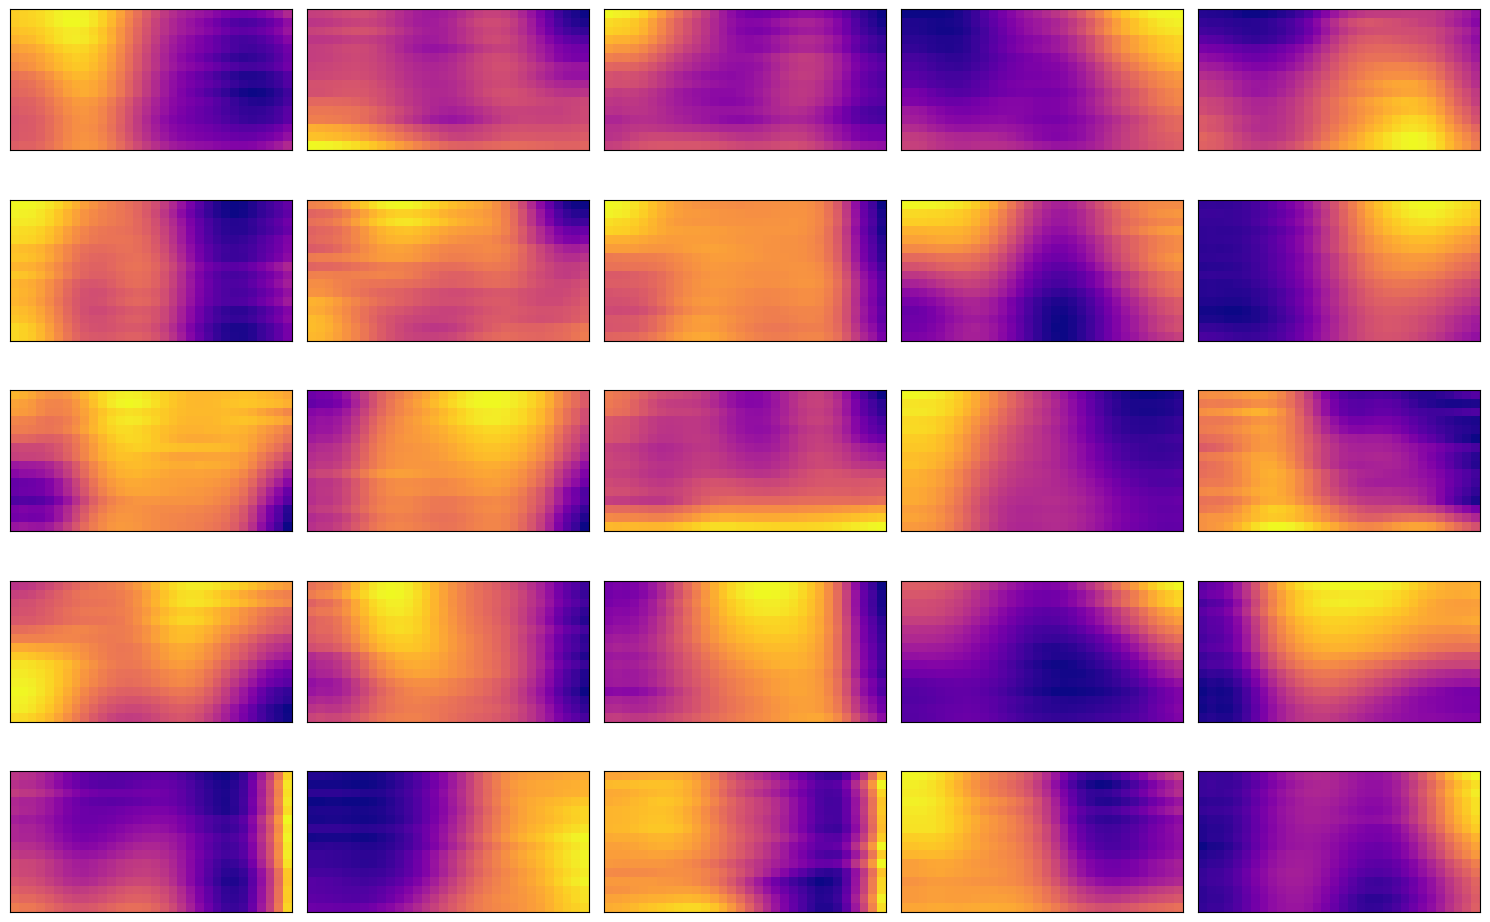

In [5]:
model.load("best_model_checkpoint.pt")

n_samples=25
sample_unconditional=model.sample_uncond(n_samples).detach().cpu().numpy()

fig, axes = plt.subplots(5, 5, figsize=(15, 10))

for sample_idx in range(n_samples):
    ax = axes[sample_idx // 5, sample_idx % 5]
    ax.imshow(sample_unconditional[sample_idx, 0, :, :], cmap='plasma')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

The model is now generating sensible higher frequency information and generating some bimodal volatility shocks which are common nowadays on short-maturity SPX options. We can also visualise the diffusion flow of one sample from pure noise to final image (a gif of this is in the readme file of this repo).

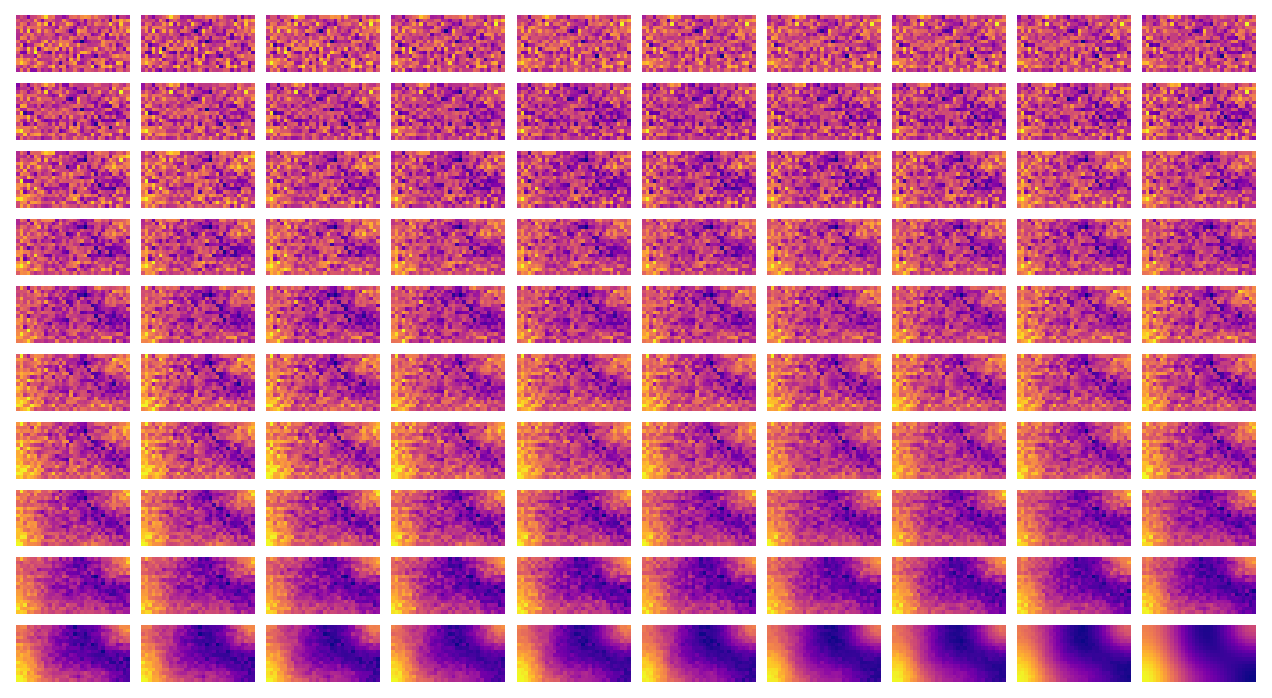

In [12]:
sample=model.sample_uncond(1,return_history=True)
fig, axes = plt.subplots(10, 10, figsize=(10, 5.5),dpi=160)

def resampler(n):
    return int(np.sqrt(n*1000))

for i in range(10):
    for j in range(10):
        axes[i,j].imshow(sample[resampler(i*100+j*10+9)].detach().cpu().numpy()[0,0,:,:], cmap='plasma')
        axes[i,j].axis('off')
        axes[i,j].invert_yaxis()
        plt.subplots_adjust(hspace=0.0, wspace=0.1)
plt.show()

<span style="color:blue">**Step 5:** </span> Let's check what the nearest neighbour in the dataset was for some of these images - that way, we can see how the model is generalising. Furthermore, we can plot the first few principal components of the generated and original data to compare whether they align.
<style>
  h1 {
    font-size: 25px;
  }
  h2 {
    font-size: 20px;
  }
  p {
    font-size: 14px;
  }
</style>

/var/folders/wl/86rt8g7n6qzcqnm1l8yl4nsh0000gp/T/ipykernel_71859/3718004350.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  distances = torch.sum(torch.abs(dataset_normalised - sample_flattened_normalised), dim=1)


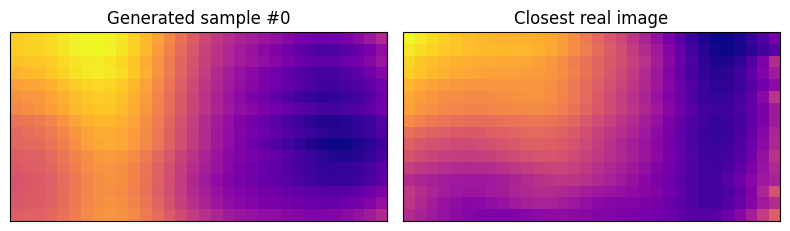

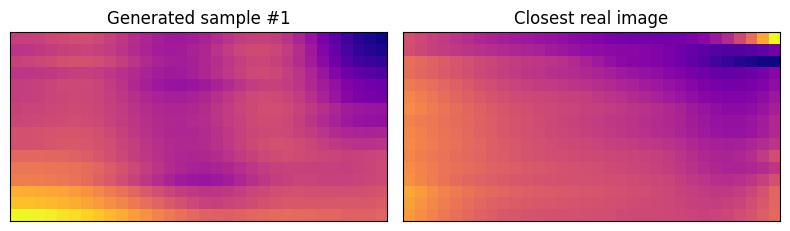

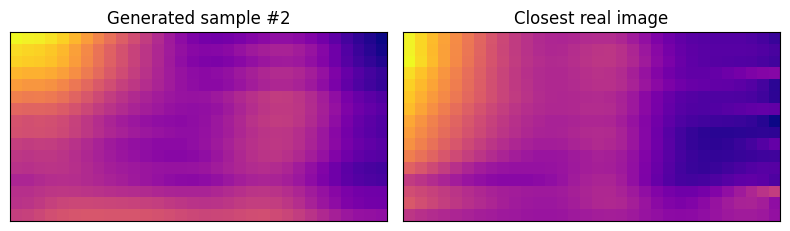

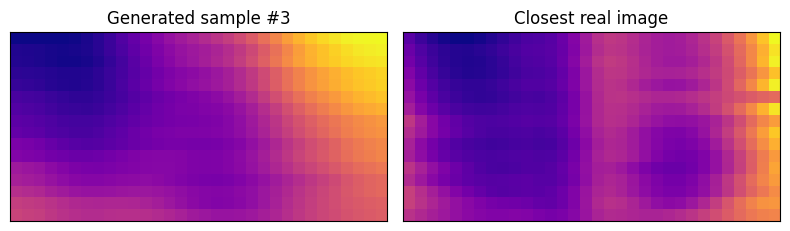

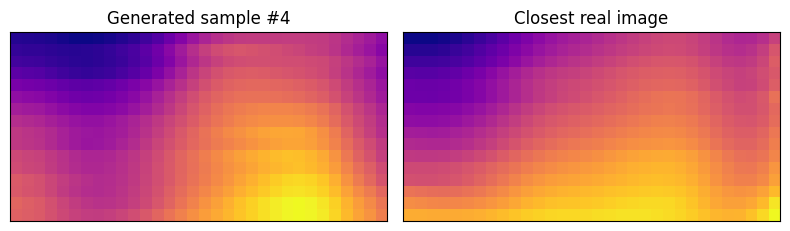

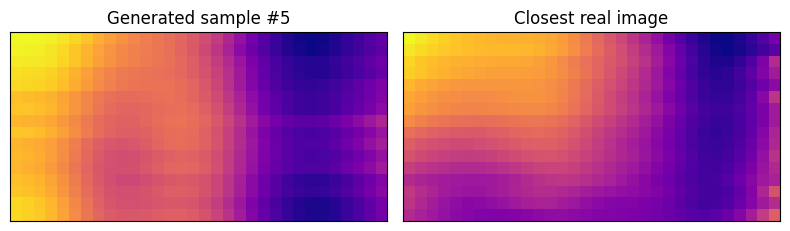

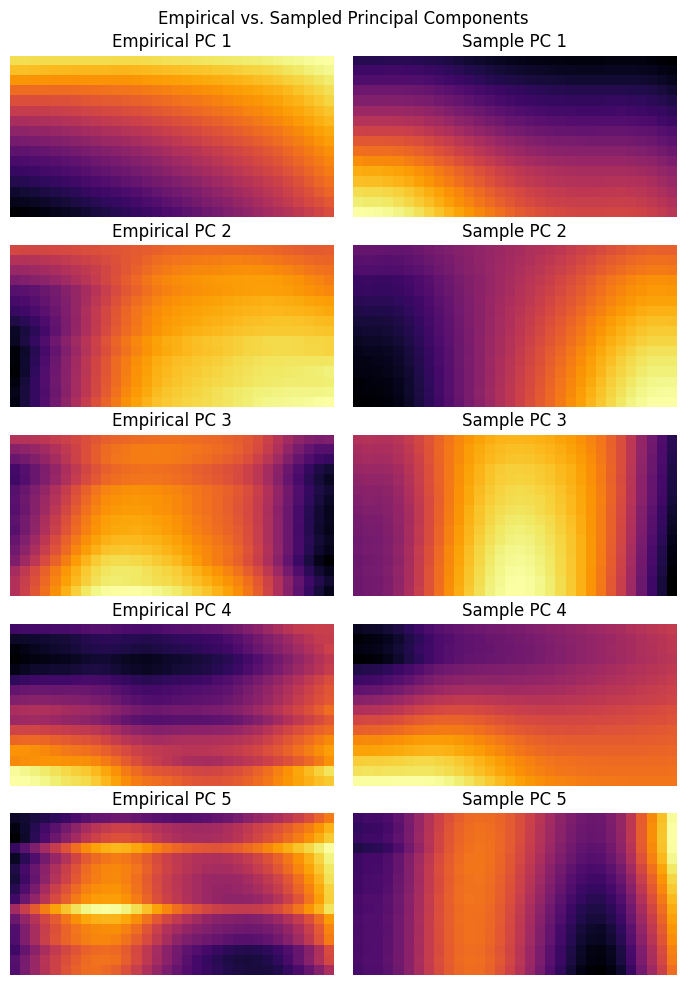

In [6]:
dataset_flat = data.view(data.shape[0], -1)
dataset_min = dataset_flat.min(dim=1, keepdim=True)[0]
dataset_max = dataset_flat.max(dim=1, keepdim=True)[0]
dataset_normalised = (dataset_flat - dataset_min) / (dataset_max - dataset_min)

for sample_idx in range(6):
    sample=sample_unconditional[sample_idx, 0, :, :]
    sample_flattened = sample.flatten()
    sample_flattened_min = sample_flattened.min()
    sample_flattened_max = sample_flattened.max()
    sample_flattened_normalised = (sample_flattened - sample_flattened_min) / (sample_flattened_max - sample_flattened_min)
    
    sample_normalised=(sample-np.min(sample))/(np.max(sample)-np.min(sample))
    
    distances = torch.sum(torch.abs(dataset_normalised - sample_flattened_normalised), dim=1)
    closest_index = torch.argmin(distances)
    closest_image = data[closest_index]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(sample, cmap='plasma')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].invert_yaxis()
    axes[0].set_title(f'Generated sample #{sample_idx}')
    axes[1].imshow(closest_image.squeeze(), cmap='plasma')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].invert_yaxis()
    axes[1].set_title('Closest real image')
    plt.tight_layout()
    plt.show()

U, S, Vt = np.linalg.svd(dataset_flat.numpy()-np.mean(dataset_flat.numpy(),axis=0), full_matrices=False)
pc_real = Vt[:5].reshape(5, 16, 32)

n=300
sample_massive=model.sample_uncond(n).detach().cpu().view(n,-1).numpy()
U, S, Vt = np.linalg.svd(sample_massive-np.mean(sample_massive,axis=0), full_matrices=False)
pc_sample = Vt[:5].reshape(5, 16, 32)

fig, axes = plt.subplots(5, 2, figsize=(7, 10))

for i in range(5):
    pc_real[i]=-pc_real[i]*np.sign(pc_real[i,-1,0])
    axes[i,0].imshow(pc_real[i], cmap='inferno')
    axes[i,0].set_title(f"Empirical PC {i+1}")
    axes[i,0].axis('off')
    axes[i,0].invert_yaxis()

    pc_sample[i]=-pc_sample[i]*np.sign(pc_sample[i,-1,0]*np.dot(pc_sample[i].flatten(),pc_real[i].flatten()))
    axes[i,1].imshow(pc_sample[i], cmap='inferno')
    axes[i,1].set_title(f"Sample PC {i+1}")
    axes[i,1].axis('off')
    axes[i,1].invert_yaxis()

plt.suptitle("Empirical vs. Sampled Principal Components")
plt.tight_layout()
plt.show()

We see clear evidence of sensible generalisation - principal components match (up to sign), and the generated volatility shocks look like mixtures of original samples, just as one would expect for diffusion models. In particular, the diffusion model still generates smooth surfaces, which is important because high-frequency information in volatility shocks will likely not be predictive out-of-sample (or not tradable). Moreover, there are stripey arifacts in the fourth and fifth empirical principal components due to bad data. The model has learnt to smooth these due to the design of the denoising network!

<span style="color:blue">**Step 6:** </span> Let's sample in a conditional manner, i.e. we seek to generate shocks based on some conditioning signal like "SPX will go down violently tomorrow". By searching the training set for shocks tagged with this query (filtering for instance on SPX return < -2%), we obtain a target subset which we can condition on. While classifier- and classifier-free guidance are popular, an unconditional diffusion model can actually condition on a subset of the training set in closed form! Simply diffuse the subset (but not fully!) and then denoise again with the diffusion model. The conditioning - choosing the subset - is thereby left to the quant, allowing *VolaDiff* to be trained just once and used as a base model in arbitrary ways. The time spent diffusing trades target adherence against sample diversity - zero diffusion time simply resamples the subset, while full diffusion destroys all information and therefore corresponds to unconditional diffusion. Below we show the effect of this hyperparameter on the conditioning query "SPX return in the worst 10% of days" by plotting the conditional means of the predictions.
<style>
  h1 {
    font-size: 25px;
  }
  h2 {
    font-size: 20px;
  }
  p {
    font-size: 14px;
  }
</style>

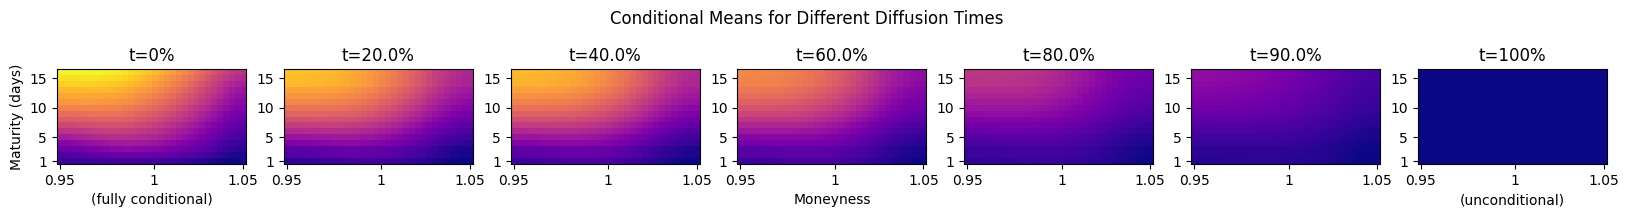

In [7]:
from torch.utils.data import Dataset, DataLoader

file_conditional="vol_data_conditional.pt" #volatility shocks filtered for SPX return in the worst 10% of days
data_conditional = torch.load(file_conditional, weights_only=True).type(torch.float32)

class ConditionalDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset_conditional = ConditionalDataset(data_conditional)
dataloader = DataLoader(dataset_conditional, shuffle=True) #package the data into a DataLoader to feed it to the model

hyperparams=[0,0.2,0.4,0.6,0.8,0.9,1]
fig,axes=plt.subplots(1,7,figsize=(20,2.2))
axes[3].set_xlabel('Moneyness')
axes[0].set_ylabel('Maturity (days)')
axes[0].set_xlabel('(fully conditional)')
axes[-1].set_xlabel('(unconditional)')

for i, param in enumerate(hyperparams):
    sample_conditional=model.sample_cond(100,dataloader,conditioning_time=param).detach().cpu().numpy()
    if i==0:
        vmin=sample_conditional[:, 0, :, :].mean(axis=0).min()
        vmax=sample_conditional[:, 0, :, :].mean(axis=0).max()
    axes[i].imshow(sample_conditional[:, 0, :, :].mean(axis=0), cmap='plasma',vmin=vmin,vmax=vmax)
    axes[i].invert_yaxis()
    
    axes[i].set_xticks([0, images[i].shape[2] // 2, images[i].shape[2] - 1])
    axes[i].set_xticklabels([0.95,1,1.05])
    axes[i].set_yticks([0, 4, 9,14])
    axes[i].set_yticklabels([1,5,10,15])
    axes[i].set_title(f"t={param*100}%")
plt.suptitle("Conditional Means for Different Diffusion Times")
plt.show()

Notice in particular the typical put volatility skew (in the top left corner) that forms when the SPX experiences a strongly negative return. The model is able to continuously interpolate between resampling the target dataset and the full dataset, finally proving that *VolaDiff* satisfies two important requirements for a generative volatility model:

- *VolaDiff* is able to fit the training set and interpolate and extrapolate volatility shocks (arbitrage-free if necessary)
- *VolaDiff* is able to condition its outputs on arbitrary signals via closed-form diffusion resampling

In summary, *VolaDiff* is a viable framework for entirely model-free volatility surface forecasting with arbitrarily high model-capacity and great flexibility for conditioning.

There are many possible extensions to *VolaDiff*. A potentially fruitful idea would be to relate *VolaDiff* to volatility derivatives such as VIX futures. The overnight VIX difference can be written approximately as a non-linear functional of the 30DTE row of the volatility shocks (non-linear since we work with implied variances so the Carr-Madan formula requires a modification) so the outputs of *VolaDiff* can be used to price VIX and variance futures. Another idea is to train on intraday volatility shocks instead of overnight shocks. This avoids the intricate definition of the overnight shocks in the paper. Many interesting features of the volatility surface are captured by intraday shocks - famous examples include the skew-stickiness ratio and the negative spot-vol correlation for index options, but there are many more data-driven discoveries to be made...